In [2]:
!pip install opendatasets --upgrade --quiet

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import opendatasets as od
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używam urządzenia: {device}")

Używam urządzenia: cuda


In [4]:
import opendatasets as od
import os

dataset_url = 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia'

od.download(dataset_url)

data_dir = './chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')

print("Dane pobrane!")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: viktoriiatsiupiak
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [00:21<00:00, 116MB/s] 



Dane pobrane!


## Krok 3. Przygotowanie danych i transformacje
Przygotowywaliśmy potok danych (pipeline). Zdjęcia rentgenowskie miały różne rozmiary, dlatego musieliśmy je ujednolicić. Sieć neuronowa typu ResNet standardowo oczekiwała wejścia o wymiarach 224×224 pikseli. Kluczową modyfikacją było wymuszenie 1 kanału (grayscale). Standardowe sieci były uczone na zdjęciach kolorowych (RGB – 3 kanały), ale zdjęcia RTG były z natury czarno-białe. Przystosowanie danych do 1 kanału oszczędzało zasoby obliczeniowe. Dodatkowo stosowaliśmy augmentację danych (losowe odbicia lustrzane i obroty) jedynie dla zbioru treningowego, aby zapobiec przeuczeniu i sprawić, by model uczył się cech choroby, a nie konkretnych ujęć.

*Co mamy w wyniku?* Mamy solidną bazę ponad 5000 zdjęć do nauki. Poprawnie zmapowane foldery na klasy binarne: 0 dla zdrowych płuc i 1 dla zapalenia płuc.

In [5]:
# Transformacje dla obrazów RTG (1 kanał)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Wczytanie datasetów
train_set = ImageFolder(root=train_dir, transform=transform_train)
test_set = ImageFolder(root=test_dir, transform=transform_test)

# DataLoadery
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

print(f"Liczba obrazów treningowych: {len(train_set)}")
print(f"Liczba obrazów testowych/walidacyjnych: {len(test_set)}")
print(f"Klasy: {train_set.class_to_idx}")

Liczba obrazów treningowych: 5216
Liczba obrazów testowych/walidacyjnych: 624
Klasy: {'NORMAL': 0, 'PNEUMONIA': 1}


## Krok 4. Wybór i konfiguracja architektury ResNet.
Zdefiniowaliśmy architekturę sieci opartą na ResNet (Residual Network). Jest to głęboka sieć konwolucyjna wykorzystująca tzw. połączenia rezydualne (res_connection), co umożliwia trenowanie bardzo głębokich struktur bez problemu zanikającego gradientu. Nasza wersja **SimpleResNet** została zmodyfikowana w pierwszej warstwie (*self.stem*), aby przyjmowała 1 kanał wejściowy (zamiast standardowych 3), co idealnie pasowało do naszych przetworzonych zdjęć RTG. Na wyjściu sieci (*self.fc*) ustawiliśmy 2 neurony odpowiadające naszym dwóm klasom.


In [9]:
class BasicBlock(nn.Module):
    multiplier = 1
    def __init__(self, input_num_planes, num_planes, strd=1):
        super(BasicBlock, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=input_num_planes, out_channels=num_planes, kernel_size=3, stride=strd, padding=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(num_planes)
        self.conv_layer2 = nn.Conv2d(in_channels=num_planes, out_channels=num_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(num_planes)

        self.res_connection = nn.Sequential()
        if strd != 1 or input_num_planes != self.multiplier * num_planes:
            self.res_connection = nn.Sequential(
                nn.Conv2d(in_channels=input_num_planes, out_channels=self.multiplier * num_planes, kernel_size=1, stride=strd, bias=False),
                nn.BatchNorm2d(self.multiplier * num_planes)
            )

    def forward(self, inp):
        op = F.relu(self.batch_norm1(self.conv_layer1(inp)))
        op = self.batch_norm2(self.conv_layer2(op))
        op += self.res_connection(inp)
        op = F.relu(op)
        return op

class SimpleResNet(nn.Module):
    def __init__(self, num_blocks_per_stage, num_classes=2):
        super(SimpleResNet, self).__init__()
        self.in_planes = 64
        self.stem = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer1 = self._make_stage(num_planes=64,  num_blocks=num_blocks_per_stage[0], stride=1)
        self.layer2 = self._make_stage(num_planes=128, num_blocks=num_blocks_per_stage[1], stride=2)
        self.layer3 = self._make_stage(num_planes=256, num_blocks=num_blocks_per_stage[2], stride=2)
        self.layer4 = self._make_stage(num_planes=512, num_blocks=num_blocks_per_stage[3], stride=2)

        self.fc = nn.Linear(512 * BasicBlock.multiplier, num_classes)

    def _make_stage(self, num_planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        blocks = []
        for s in strides:
            blocks.append(BasicBlock(self.in_planes, num_planes, strd=s))
            self.in_planes = num_planes * BasicBlock.multiplier
        return nn.Sequential(*blocks)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool2d(x, x.size()[2:])
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [12]:
print(model)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("-" * 50)
print(f"Model gotowy do pracy na urządzeniu: {device}")
print(f"Liczba trenowalnych parametrów: {total_params:,}")
print("-" * 50)

SimpleResNet(
  (stem): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv_layer1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_layer2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (res_connection): Sequential()
    )
    (1): BasicBlock(
      (conv_layer1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_layer2): Conv2d(64, 64, kernel_size=

## Krok 5. Inicjalizacja treningu.
W tym kroku tworzyliśmy instancję modelu i przenosiliśmy ją do pamięci karty graficznej (device). Definiowaliśmy dwa kluczowe elementy procesu uczenia: funkcję straty, dla której używaliśmy CrossEntropyLoss będącej standardem w problemach klasyfikacji, oraz optymalizator Adam z learning rate 0.001, który okazał się szybkim i skutecznym algorytmem adaptacyjnym. Dodatkowo wykorzystywaliśmy scheduler, który zmieniał tempo uczenia w trakcie epok, co pomagało modelowi ustabilizować się w minimum funkcji błędu.


In [15]:

model = SimpleResNet(num_blocks_per_stage=[2, 2, 2, 2], num_classes=2)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5) # T_max dopasować do ilości epok!

## Krok 6. Training Loop.
Przez 5 epok model iteracyjnie:

- Uczy się (Train): Widzi zdjęcia, zgaduje wynik, liczy błąd i aktualizuje swoje wagi.

- Waliduje się (Eval): Sprawdza swoją wiedzę na zbiorze testowym, którego nigdy wcześniej nie widział. Ważnym elementem jest mechanizm checkpointingu: zapisujemy model (best_pneumonia_model.pth) tylko wtedy, gdy osiągnie on najlepszy wynik na walidacji

*Co pokazał nam wynik?*

Obserwujemy klasyczne zjawisko przeuczenia (overfitting). Model osiągnął szczyt swoich możliwości w 2. epoce (83.01%). W kolejnych epokach Train Loss nadal spadał (0.17 -> 0.11), co oznacza, że model uczył się na pamięć zbioru treningowego, ale tracił zdolność generalizacji (Val Loss rósł, a Accuracy spadało). Dzięki zapisowi najlepszego modelu, zachowaliśmy wersję z 2. epoki.

In [16]:
num_epochs = 5
train_losses = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0

print("Rozpoczynam trening...")

for epoch in range(num_epochs):
    # ---- TRAIN ----
    model.train()
    running_train_loss = 0.0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model.eval()
    running_val_loss = 0.0
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            running_val_loss += criterion(output, target).item()

            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_acc = 100.0 * correct / len(val_loader.dataset)
    val_accuracies.append(val_acc)

    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_pneumonia_model.pth")

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

print(f"Trening zakończony. Najlepsze Accuracy: {best_val_acc:.2f}%")

Rozpoczynam trening...
Epoch 1/5 | Train Loss: 0.2747 | Val Loss: 1.4423 | Val Acc: 56.57%
Epoch 2/5 | Train Loss: 0.1794 | Val Loss: 0.4103 | Val Acc: 83.01%
Epoch 3/5 | Train Loss: 0.1537 | Val Loss: 0.8723 | Val Acc: 76.12%
Epoch 4/5 | Train Loss: 0.1292 | Val Loss: 0.6716 | Val Acc: 79.49%
Epoch 5/5 | Train Loss: 0.1143 | Val Loss: 0.9621 | Val Acc: 73.24%
Trening zakończony. Najlepsze Accuracy: 83.01%


## Wizualizacja przebiegu uczenia
**Loss:** Widzimy tzw. "nożyce". Linia treningowa (niebieska) spada, ale linia walidacyjna (pomarańczowa) po 2. epoce gwałtownie odbija w górę. To wizualny dowód na to, że dalsze trenowanie bez dodatkowej regularyzacji nie przynosi korzyści.

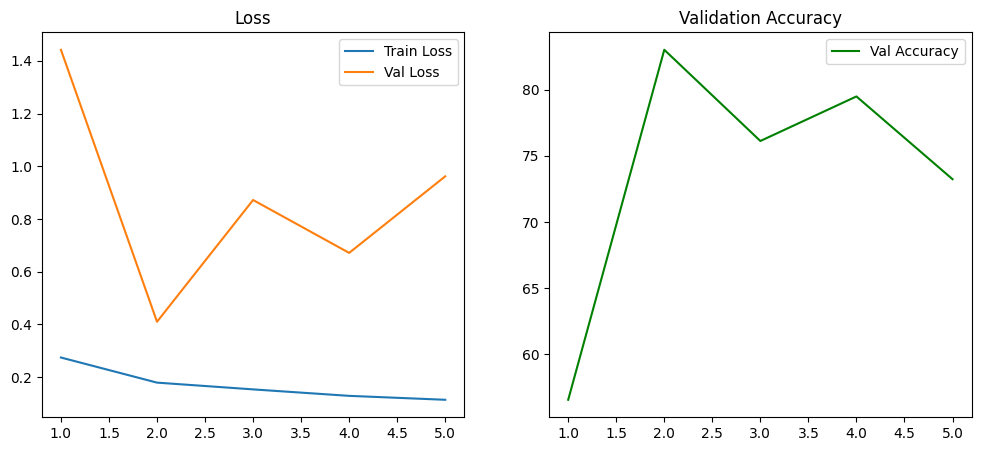

In [17]:
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.title('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, label='Val Accuracy', color='green')
plt.title('Validation Accuracy')
plt.legend()

plt.show()

## Wizualna weryfikacja predykcji
Wczytaliśmy z dysku nasz najlepszy model (ten z 2. epoki) i sprawdziliśmy jego dokładność, wyświetlając losową próbkę 6 zdjęć ze zbioru testowego wraz z predykcją modelu oraz stanem faktycznym.

- Zielony napis: Predykcja poprawna.

- Czerwony napis: Pomyłka modelu.

Widzimy, że sieć potrafi poprawnie rozróżnić "PNEUMONIA" od "NORMAL", choć zdarzają się pomyłki, co jest naturalne przy skuteczności na poziomie ~83%.

Oto LOSOWE wyniki (uruchom ponownie, aby wylosować inne):


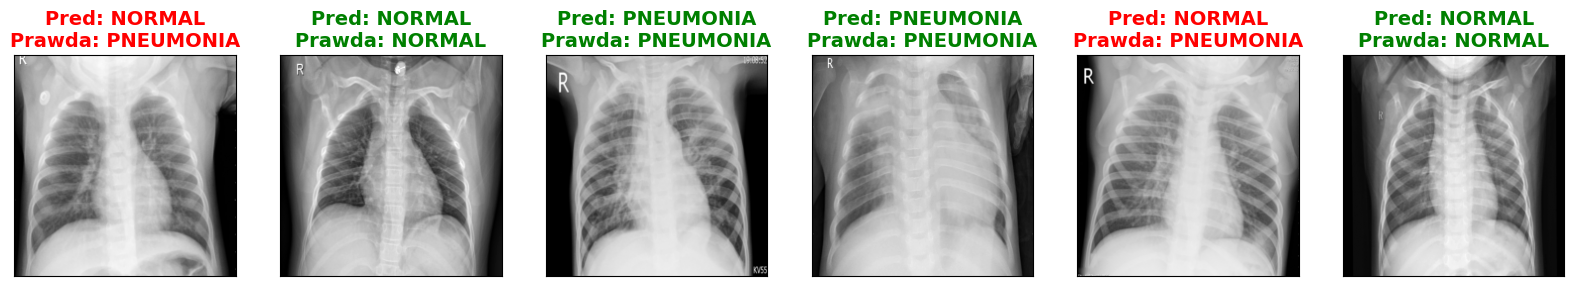

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')


model.load_state_dict(torch.load("best_pneumonia_model.pth"))
model.to(device)
model.eval()

viz_loader = DataLoader(test_set, batch_size=6, shuffle=True)

dataiter = iter(viz_loader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

output = model(images)
_, preds = torch.max(output, 1)

class_names = ['NORMAL', 'PNEUMONIA']

fig = plt.figure(figsize=(20, 8))
print("Oto LOSOWE wyniki (uruchom ponownie, aby wylosować inne):")

for idx in range(6):
    ax = fig.add_subplot(1, 6, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

    pred_label = class_names[preds[idx]]
    true_label = class_names[labels[idx]]

    color = "green" if pred_label == true_label else "red"

    ax.set_title(f"Pred: {pred_label}\nPrawda: {true_label}", color=color, fontsize=14, fontweight='bold')

plt.show()

## Macierz pomyłek
- Skuteczność całkowita: (186 + 332) / 624 ≈ 83%.

- False Negative (58): To najbardziej krytyczny błąd – 58 pacjentów z zapaleniem płuc zostało uznanych za zdrowych. Stanowi to ok. 15% wszystkich chorych w zbiorze testowym.

- False Positive (48): 48 zdrowych osób zostało błędnie zdiagnozowanych jako chore.

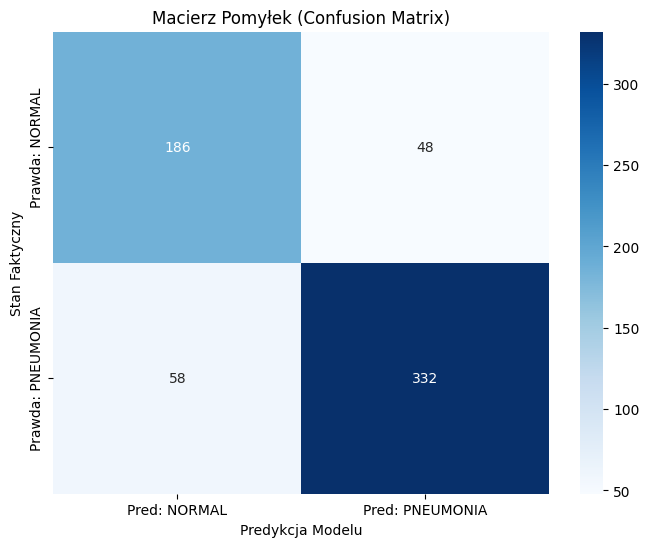

Poprawnie wykryci ZDROWI (True Negative): 186
Fałszywe alarmy (False Positive): 48
Niewykryta choroba (False Negative): 58  <-- Najważniejszy błąd
Poprawnie wykryci CHORZY (True Positive): 332


In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, preds = torch.max(output, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
tn, fp, fn, tp = cm.ravel()

#  WYKRES
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: NORMAL', 'Pred: PNEUMONIA'],
            yticklabels=['Prawda: NORMAL', 'Prawda: PNEUMONIA'])
plt.ylabel('Stan Faktyczny')
plt.xlabel('Predykcja Modelu')
plt.title('Macierz Pomyłek (Confusion Matrix)')
plt.show()

print(f"Poprawnie wykryci ZDROWI (True Negative): {tn}")
print(f"Fałszywe alarmy (False Positive): {fp}")
print(f"Niewykryta choroba (False Negative): {fn}")
print(f"Poprawnie wykryci CHORZY (True Positive): {tp}")